In [69]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense, Dropout, Flatten, Add,  Input, MaxPooling1D, concatenate, LSTM 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## Hiperparametros generales

In [70]:

epochs = 400
batch_size = 32


## MLP

In [71]:
# Definir el número de neuronas en función de la longitud de la serie temporal y el número de capas ocultas
def create_mlp(input_shape, num_classes, num_layers=3):
    model = Sequential()
    model.add(Dense(units=input_shape[1], input_shape=input_shape, activation='relu'))
    for i in range(num_layers):
        neurons = input_shape[1] * (num_layers - i)
        model.add(Dense(units=neurons, activation='relu'))
        model.add(Dropout(0.3 / (2 ** i)))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [ ]:
# Ajustar el input_shape correctamente
input_shape = (X_train.shape[1], X_train.shape[2])  # Usar solo dos dimensiones
print(input_shape[1])
num_classes = y_train.shape[1]
model = create_mlp(input_shape, num_classes, num_layers=3)
model.summary()

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# Callback para reducir el learning rate en plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, verbose=2,
                    callbacks=[early_stopping, reduce_lr])

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

## FCN

In [73]:
# Función para crear el modelo FCN
def create_fcn_model(input_shape, num_classes):
    model = Sequential()

    # Primera capa convolucional
    model.add(Conv1D(filters=128, kernel_size=8, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Segunda capa convolucional
    model.add(Conv1D(filters=256, kernel_size=5, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Tercera capa convolucional
    model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Capa de Global Average Pooling
    model.add(GlobalAveragePooling1D())

    # Capa de salida (softmax)
    model.add(Dense(num_classes, activation='softmax'))

    return model




In [59]:
input_shape = (X_train.shape[1], X_train.shape[2])  # Dimensiones de entrada de la serie temporal
num_classes = y_train.shape[1]  # Número de clases (asumiendo one-hot encoding)
model = create_fcn_model(input_shape, num_classes)
model.summary()

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
loss='categorical_crossentropy', metrics=['accuracy'])

# Reducir la tasa de aprendizaje cuando el progreso sea lento
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=2, callbacks=[early_stopping, reduce_lr])

# Mostrar el resumen de la arquitectura del modelo


# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_687 (Conv1D)         (None, 1, 128)            1228928   
                                                                 
 batch_normalization_796 (Ba  (None, 1, 128)           512       
 tchNormalization)                                               
                                                                 
 re_lu_546 (ReLU)            (None, 1, 128)            0         
                                                                 
 conv1d_688 (Conv1D)         (None, 1, 256)            164096    
                                                                 
 batch_normalization_797 (Ba  (None, 1, 256)           1024      
 tchNormalization)                                               
                                                                 
 re_lu_547 (ReLU)            (None, 1, 256)          

## ResNet

In [74]:

def residual_block(x, filters, kernel_size=3):
    # Primera convolución
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size, padding='same', kernel_regularizer=l2(0.01))(x)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

    # Segunda convolución
    conv2 = Conv1D(filters=filters, kernel_size=kernel_size, padding='same', kernel_regularizer=l2(0.01))(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)

    # Tercera convolución
    conv3 = Conv1D(filters=filters, kernel_size=kernel_size, padding='same', kernel_regularizer=l2(0.01))(conv2)
    conv3 = BatchNormalization()(conv3)

    # Proyección para hacer coincidir las dimensiones de entrada y salida
    shortcut = Conv1D(filters=filters, kernel_size=1, padding='same', kernel_regularizer=l2(0.01))(x)
    shortcut = BatchNormalization()(shortcut)

    # Agregar la conexión residual (entrada proyectada)
    output = Add()([shortcut, conv3])
    output = ReLU()(output)

    return output

# Función para crear el modelo ResNet
def create_resnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Primer bloque residual
    x = residual_block(inputs, filters=64)

    # Segundo bloque residual
    x = residual_block(x, filters=128)

    # Tercer bloque residual
    x = residual_block(x, filters=128)

    # Capa de Global Average Pooling
    x = GlobalAveragePooling1D()(x)

    # Capa de salida (softmax)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Definir el modelo
    model = Model(inputs=inputs, outputs=outputs)

    # Compilar el modelo
    

    return model




In [ ]:
# Crear el modelo ResNet
input_shape = (X_train.shape[1], X_train.shape[2])  # Dimensión de entrada
num_classes = y_train.shape[1]  # Número de clases (asumiendo que y_train es one-hot encoded)
model = create_resnet_model(input_shape, num_classes)

model.summary()

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=2, callbacks=[early_stopping, reduce_lr])

# Mostrar el resumen de la arquitectura del modelo


# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

## IncepctionFCN

In [75]:
# Función para crear un bloque de Inception
def inception_block(input_tensor, filters):
    # Convolución 1x1
    conv1 = Conv1D(filters=filters, kernel_size=1, padding='same', activation=None)(input_tensor)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

    # Convolución 10x1
    conv10 = Conv1D(filters=filters, kernel_size=10, padding='same', activation=None)(conv1)
    conv10 = BatchNormalization()(conv10)
    conv10 = ReLU()(conv10)

    # Convolución 20x1
    conv20 = Conv1D(filters=filters, kernel_size=20, padding='same', activation=None)(conv10)
    conv20 = BatchNormalization()(conv20)
    conv20 = ReLU()(conv20)

    # MaxPooling seguido de convolución 1x1
    pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    pool_conv = Conv1D(filters=filters, kernel_size=1, padding='same', activation=None)(pool)
    pool_conv = BatchNormalization()(pool_conv)
    pool_conv = ReLU()(pool_conv)

    # Concatenación de las salidas
    output = concatenate([conv1, conv10, conv20, pool_conv], axis=-1)
    
    return output

# FCN block basado en las imágenes proporcionadas
def fcn_block(input_tensor):
    # Seis capas de convolución, cada una con tamaño de filtro 128 y diferentes tamaños de kernel
    x = Conv1D(filters=128, kernel_size=1, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(filters=128, kernel_size=5, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(filters=128, kernel_size=5, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(filters=128, kernel_size=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    return x

# Creación del modelo InceptionFCN
def create_inceptionfcn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Módulo Inception (dos bloques como se indica en la descripción)
    x = inception_block(inputs, filters=64)
    x = inception_block(x, filters=64)

    # Módulo FCN (Shortcut module)
    fcn_output = fcn_block(inputs)

    # Concatenar la salida del módulo Inception y el FCN (shortcut module)
    combined = concatenate([x, fcn_output])

    # Global Average Pooling seguido de Dropout
    combined = GlobalAveragePooling1D()(combined)
    combined = Dropout(0.5)(combined)
    
    # Capa de salida softmax
    outputs = Dense(num_classes, activation='softmax')(combined)
    
    # Definir el modelo
    model = Model(inputs=inputs, outputs=outputs)
    

    
    return model

# Mostrar resumen del modelo


In [ ]:
model.summary()
input_shape = (X_train.shape[1], X_train.shape[2])   # Ajustar a la dimensión de tus datos
num_classes = y_train.shape[1]      # Ajustar al número de clases en tu dataset

model = create_inceptionfcn_model(input_shape, num_classes)

# Compilar el modelo con Adam y una tasa de aprendizaje de 1e-3
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks para Early Stopping y reducción de la tasa de aprendizaje
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Entrenamiento (X_train y y_train deben estar preparados previamente)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=2, callbacks=[early_stopping, reduce_lr])

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

## S2swa

In [76]:
# Definir el Encoder-Decoder LSTM

def encoder_decoder_lstm(input_shape, n_units=15, target_length=15, dropout_rate=0.3, l2_reg=1e-3):
    inputs = Input(shape=input_shape)
    x = inputs
    # Tres capas LSTM con Batch Normalization, Regularización L2 y Dropout (Encoder)
    for _ in range(2):
        x = LSTM(n_units, return_sequences=True, kernel_regularizer=l2(l2_reg))(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
    encoder_output, state_h, state_c = LSTM(n_units, return_sequences=True, return_state=True, kernel_regularizer=l2(l2_reg))(x)
    encoder_states = [state_h, state_c]
    
    # Longitud de salida fija L (Decoder)
    decoder_lstm_layer = LSTM(n_units, return_sequences=True, return_state=True, kernel_regularizer=l2(l2_reg))
    decoder_outputs, _, _ = decoder_lstm_layer(encoder_output, initial_state=encoder_states)
    # Dos capas LSTM con Batch Normalization y Dropout
    for _ in range(1):
        decoder_outputs = LSTM(n_units, return_sequences=True, kernel_regularizer=l2(l2_reg))(decoder_outputs)
        decoder_outputs = BatchNormalization()(decoder_outputs)
        decoder_outputs = Dropout(dropout_rate)(decoder_outputs)
    
    return inputs, decoder_outputs

# Definir el modelo S2SwA
def create_s2swa_model(input_shape, target_length, num_classes, n_units=15, fc_units=400, dropout_rate=0.3, l2_reg=1e-3):
    # Encoder-Decoder
    inputs, decoder_outputs = encoder_decoder_lstm(input_shape, n_units, target_length, dropout_rate, l2_reg)
    
    # Capa totalmente conectada
    fc = Dense(fc_units, activation='relu', kernel_regularizer=l2(l2_reg))(decoder_outputs)
    fc = Dropout(0.5)(fc)
    
    # Aplanar antes de la capa de salida
    fc = Flatten()(fc)
    
    # Capa de salida
    outputs = Dense(num_classes, activation='softmax')(fc)
    
    # Definir el modelo completo
    model = Model(inputs, outputs)
    
    # Compilar el modelo con SGD y momentum
    
    
    return model

# Mostrar el resumen del modelo




In [ ]:

# Crear el modelo
input_shape = (X_train.shape[1], X_train.shape[2])  # Ajustar al tamaño de entrada de tus datos
target_length = 15     # Longitud fija para la secuencia de salida (L)
num_classes = y_train.shape[1]       # Número de clases en el dataset
model = create_s2swa_model(input_shape, target_length, n_units=15, num_classes=num_classes, dropout_rate=0.3, l2_reg=1e-3)
model.summary()

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
# Callbacks para Early Stopping y reducción de la tasa de aprendizaje
# Callbacks para Early Stopping y reducción de la tasa de aprendizaje
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Entrenamiento del modelo
# X_train y y_train del mismo conjunto usado en los modelos anteriores
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=2, callbacks=[early_stopping, reduce_lr])

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

## CONV-LSTM

In [78]:
class Model_CONV_LSTM(Model):
    def __init__(self, num_n_deep=[64, 64, 512, 264, 6], drop_out=[0.3, 0.3], **kwargs):
        super(Model_CONV_LSTM, self).__init__()

        self.num_classes = num_n_deep[-1]  # Asumimos que la última posición de num_n_deep indica el número de clases
        self.num_n_deep = num_n_deep
        self.drop_out = drop_out

        # Inicialización de capas en el constructor
        # Capas Conv1D con diferentes filtros
        self.Pred_Layer1_conv1 = layers.Conv1D(filters=32, kernel_size=32, padding='same', activation='relu')
        self.Pred_Layer1_BatchNorm = layers.BatchNormalization()  # BatchNormalization después de la capa Conv1D
        self.Pred_Layer2_conv2 = layers.Conv1D(filters=32, kernel_size=16, padding='same', activation='relu')
        self.Pred_Layer2_BatchNorm = layers.BatchNormalization()
        self.Pred_Layer3_conv3 = layers.Conv1D(filters=32, kernel_size=8, padding='same', activation='relu')
        self.Pred_Layer3_BatchNorm = layers.BatchNormalization()

        # Aumentar el número de capas LSTM
        self.Pred_Layer5_LSTM = layers.LSTM(units=self.num_n_deep[1], return_sequences=True, dropout=0.3, kernel_regularizer=tf.keras.regularizers.L2(0.007))
        self.Pred_Layer5_LayerNorm = layers.LayerNormalization()  # LayerNormalization después de LSTM
        self.Pred_Layer6_LSTM = layers.LSTM(units=self.num_n_deep[1], return_sequences=True, dropout=0.3, kernel_regularizer=tf.keras.regularizers.L2(0.007))
        self.Pred_Layer6_LayerNorm = layers.LayerNormalization()  # LayerNormalization después de LSTM
        self.Pred_Layer7_LSTM = layers.LSTM(units=self.num_n_deep[1], return_sequences=True, dropout=0.4, kernel_regularizer=tf.keras.regularizers.L2(0.007))
        self.Pred_Layer7_LayerNorm = layers.LayerNormalization()  # LayerNormalization después de LSTM
        self.Pred_Layer8_LSTM = layers.LSTM(units=self.num_n_deep[1], return_sequences=True, dropout=0.4, kernel_regularizer=tf.keras.regularizers.L2(0.007))
        self.Pred_Layer8_LayerNorm = layers.LayerNormalization()  # LayerNormalization después de LSTM

        # Reducir el número de capas de Atención
        self.Attention_Layer1 = layers.Attention()  # Primera capa de atención

        self.Pred_GlobalPool = layers.GlobalAveragePooling1D()
        self.Pred_Layer10_Dense = layers.Dense(units=self.num_n_deep[2], activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.007))
        self.Pred_Layer10_BatchNorm = layers.BatchNormalization()  # BatchNormalization después de Dense
        self.Pred_Layer11_Dropout = layers.Dropout(rate=self.drop_out[0])
        self.Pred_Layer12_Dense = layers.Dense(units=self.num_n_deep[3], activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.007))
        self.Pred_Layer12_BatchNorm = layers.BatchNormalization()  # BatchNormalization después de Dense
        self.Pred_Layer13_Dropout = layers.Dropout(rate=self.drop_out[1])
        self.Pred_Layer14_Dense = layers.Dense(units=self.num_classes, activation='softmax')

    def call(self, inputs, out_before=0, pas_bef=False):
        # Capas Conv1D con diferentes filtros
        x1 = self.Pred_Layer1_conv1(inputs)
        x1 = self.Pred_Layer1_BatchNorm(x1)
        x2 = self.Pred_Layer2_conv2(inputs)
        x2 = self.Pred_Layer2_BatchNorm(x2)
        x3 = self.Pred_Layer3_conv3(inputs)
        x3 = self.Pred_Layer3_BatchNorm(x3)



        # Concatenar salidas de capas Conv1D
        x = layers.Concatenate()([x1, x2, x3])

        # Capas LSTM
        x_lstm1 = self.Pred_Layer5_LSTM(inputs)
        x_lstm1 = self.Pred_Layer5_LayerNorm(x_lstm1)
        x_lstm2 = self.Pred_Layer6_LSTM(x_lstm1)
        x_lstm2 = self.Pred_Layer6_LayerNorm(x_lstm2)
        x_lstm3 = self.Pred_Layer7_LSTM(x_lstm2)
        x_lstm3 = self.Pred_Layer7_LayerNorm(x_lstm3)
        x_lstm4 = self.Pred_Layer8_LSTM(x_lstm3)
        x_lstm4 = self.Pred_Layer8_LayerNorm(x_lstm4)

        # Concatenar salidas de capas LSTM
        x = layers.Concatenate()([x_lstm1, x_lstm2, x_lstm3, x_lstm4, x])

        # Aplicar atención
        x = self.Attention_Layer1([x, x])

        # GlobalAveragePooling1D antes de las capas densas
        x = self.Pred_GlobalPool(x)

        # Capas densas
        x = self.Pred_Layer10_Dense(x)
        x = self.Pred_Layer10_BatchNorm(x)
        x = self.Pred_Layer11_Dropout(x)
        x = self.Pred_Layer12_Dense(x)
        x = self.Pred_Layer12_BatchNorm(x)
        x = self.Pred_Layer13_Dropout(x)
        if pas_bef:
            x = layers.Concatenate()([x, out_before])
        x = self.Pred_Layer14_Dense(x)
        return x




In [ ]:
# Crear y compilar el modelo
input_shape = (X_train.shape[1], X_train.shape[2])  # Ajustar al tamaño de entrada de tus datos
num_classes = y_train.shape[1]  # Número de clases en los datos de entrenamiento
model = Model_CONV_LSTM(num_n_deep=[64, 64, 512, 264, num_classes])
model.build((None, *input_shape))
# Mostrar el resumen del modelo
model.summary()
# Compilar el modelo con Adam
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks para Early Stopping y reducción de la tasa de aprendizaje
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Callback para el planificador de tasa de aprendizaje
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
learning_rate_scheduler = LearningRateScheduler(scheduler)

# Entrenamiento del modelo
history = model.fit(X_train, y_train,
                    epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=2,
                    callbacks=[early_stopping, reduce_lr, learning_rate_scheduler])

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [80]:
def load_ts_file(file_path):
    """
    Función para cargar archivos .ts y separar características y etiquetas.
    Asume que las características están separadas por comas y las etiquetas están separadas por dos puntos (:).
    """
    features = []
    labels = []

    # Leer el archivo línea por línea
    with open(file_path, 'r') as file:
        for line in file:
            # Separar características y etiquetas usando ":"
            line_split = line.strip().split(':')
            # Verificar si la línea tiene características y una etiqueta
            if len(line_split) == 2:
                # Las características están antes del ":"
                features.append([float(val) for val in line_split[0].split(',')])
                # La etiqueta está después del ":" (solo una columna, un valor)
                label = int(line_split[1].strip())  # Se elimina cualquier espacio adicional
                labels.append(label)
    # Convertir a DataFrame para las características y convertir las etiquetas en array
    X = pd.DataFrame(features)
    y = pd.DataFrame(labels, columns=['Etiqueta'])

    return X, y
# Callbacks comunes
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
learning_rate_scheduler = LearningRateScheduler(scheduler)

# Definir los modelos disponibles
model_functions = {
    'MLP': create_mlp,
    'FCN': create_fcn_model,
    'ResNet': create_resnet_model,
    'InceptionFCN': create_inceptionfcn_model,
    'Seq2SeqwA': create_s2swa_model,
    'CONV_LSTM': lambda input_shape, num_classes: Model_CONV_LSTM(num_n_deep=[64, 64, 512, 264, num_classes])
}
# Definir los datasets disponibles
file_paths_train = [
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/Z_CorrienteDesbaste/train_Corrientes.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/ElectricDeviceDetection/ElectricDeviceDetection_TRAIN.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/FaultDetectionA/FaultDetectionA_TRAIN.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/FaultDetectionB/FaultDetectionB_TRAIN.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/FordA/FordA_TRAIN.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/FordB/FordB_TRAIN.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/FreezerRegularTrain/FreezerRegularTrain_TRAIN.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/FreezerSmallTrain/FreezerSmallTrain_TRAIN.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/KeplerLightCurves/KeplerLightCurves_TRAIN.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/StarLightCurves/StarLightCurves_TRAIN.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/Wafer/Wafer_TRAIN.ts'
]

file_paths_test = [
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/Z_CorrienteDesbaste/test_Corrientes.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/ElectricDeviceDetection/ElectricDeviceDetection_TEST.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/FaultDetectionA/FaultDetectionA_TEST.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/FaultDetectionB/FaultDetectionB_TEST.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/FordA/FordA_TEST.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/FordB/FordB_TEST.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/FreezerRegularTrain/FreezerRegularTrain_TEST.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/FreezerSmallTrain/FreezerSmallTrain_TEST.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/KeplerLightCurves/KeplerLightCurves_TEST.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/StarLightCurves/StarLightCurves_TEST.ts',
    'I:/Maestria/IA/Proyecto/Proyecto/Dataset/Wafer/Wafer_TEST.ts'

]

# Inicializar DataFrame para almacenar resultados
results_df = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Precision', 'Recall', 'Training Time'])

# Bucle a través de cada dataset y cada modelo
for train_path, test_path in zip(file_paths_train, file_paths_test):
    # Cargar los datos
    X_train, y_train = load_ts_file(train_path)
    X_test, y_test = load_ts_file(test_path)

    # Preprocesamiento de datos
    y_train = pd.get_dummies(y_train, columns=['Etiqueta'])
    y_test = pd.get_dummies(y_test, columns=['Etiqueta'])
    X_train, y_train = shuffle(X_train, y_train)
    X_train = np.expand_dims(X_train, axis=1)
    X_test = np.expand_dims(X_test, axis=1)

    input_shape = (X_train.shape[1], X_train.shape[2])
    print('Numero de clases: ',y_train.shape[1])
    num_classes = y_train.shape[1]

    for model_name, model_function in model_functions.items():
        print(f"Evaluando modelo: {model_name}")
        # Crear el modelo
        if model_name == 'CONV_LSTM':
            mmodel = model_function(input_shape, num_classes)
            model.build((None, *input_shape))
        if model_name == "Seq2SeqwA":
            model = model_function(input_shape, target_length=15, num_classes=num_classes, n_units=15, fc_units=400, dropout_rate=0.3, l2_reg=1e-3)

        else:
            model = model_function(input_shape, num_classes)

        # Compilar el modelo
        model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

        # Entrenar el modelo
        start_time = time.time()
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr, learning_rate_scheduler],
            verbose=0
        )
        training_time = time.time() - start_time
        # Evaluar el modelo
        y_test = y_test.reindex(columns=y_train.columns, fill_value=0)
        # Evaluar el modelo
        scores = model.evaluate(X_test, y_test, verbose=0)
        accuracy = scores[1]
        precision = scores[2]
        recall = scores[3]

        # Almacenar resultados
        results_df = pd.concat([results_df, pd.DataFrame([{
            'Model': model_name,
            'Dataset': train_path.split('/')[-2],  # Extraer nombre del dataset
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'Training Time': training_time
        }])], ignore_index=True)

# Mostrar los resultados
print(results_df)


Numero de clases:  6
Evaluando modelo: MLP


C:\Users\cearr\AppData\Local\Temp\ipykernel_5904\2844008545.py:130: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{


Evaluando modelo: FCN
Evaluando modelo: ResNet
Evaluando modelo: InceptionFCN
Evaluando modelo: Seq2SeqwA
Evaluando modelo: CONV_LSTM
Numero de clases:  2
Evaluando modelo: MLP
Evaluando modelo: FCN
Evaluando modelo: ResNet
Evaluando modelo: InceptionFCN
Evaluando modelo: Seq2SeqwA
Evaluando modelo: CONV_LSTM
Numero de clases:  3
Evaluando modelo: MLP
Evaluando modelo: FCN
Evaluando modelo: ResNet
Evaluando modelo: InceptionFCN
Evaluando modelo: Seq2SeqwA
Evaluando modelo: CONV_LSTM
Numero de clases:  3
Evaluando modelo: MLP
Evaluando modelo: FCN
Evaluando modelo: ResNet
Evaluando modelo: InceptionFCN
Evaluando modelo: Seq2SeqwA
Evaluando modelo: CONV_LSTM
Numero de clases:  2
Evaluando modelo: MLP
Evaluando modelo: FCN
Evaluando modelo: ResNet
Evaluando modelo: InceptionFCN
Evaluando modelo: Seq2SeqwA
Evaluando modelo: CONV_LSTM
Numero de clases:  2
Evaluando modelo: MLP
Evaluando modelo: FCN
Evaluando modelo: ResNet
Evaluando modelo: InceptionFCN
Evaluando modelo: Seq2SeqwA
Evaluando

In [81]:
# Guardar los resultados en un archivo CSV
results_df.to_csv('model_comparison_results.csv', index=False)

                         Accuracy                                             \
Model                   CONV_LSTM       FCN InceptionFCN       MLP    ResNet   
Dataset                                                                        
ElectricDeviceDetection  0.891026  0.910256     0.841346  0.866987  0.894231   
FaultDetectionA          0.806085  0.817082     0.830645  0.820015  0.820381   
FaultDetectionB          0.913580  0.925926     0.962963  0.851852  0.925926   
FordA                    0.786364  0.668939     0.703788  0.752273  0.753030   
FordB                    0.704938  0.687654     0.614815  0.688889  0.659259   
FreezerRegularTrain      1.000000  0.993333     1.000000  1.000000  1.000000   
FreezerSmallTrain        1.000000  1.000000     1.000000  1.000000  1.000000   
StarLightCurves          0.949000  0.967000     0.964000  0.955000  0.956000   
Wafer                    1.000000  0.999000     0.999000  0.998000  1.000000   
Z_CorrienteDesbaste      0.922540  0.931

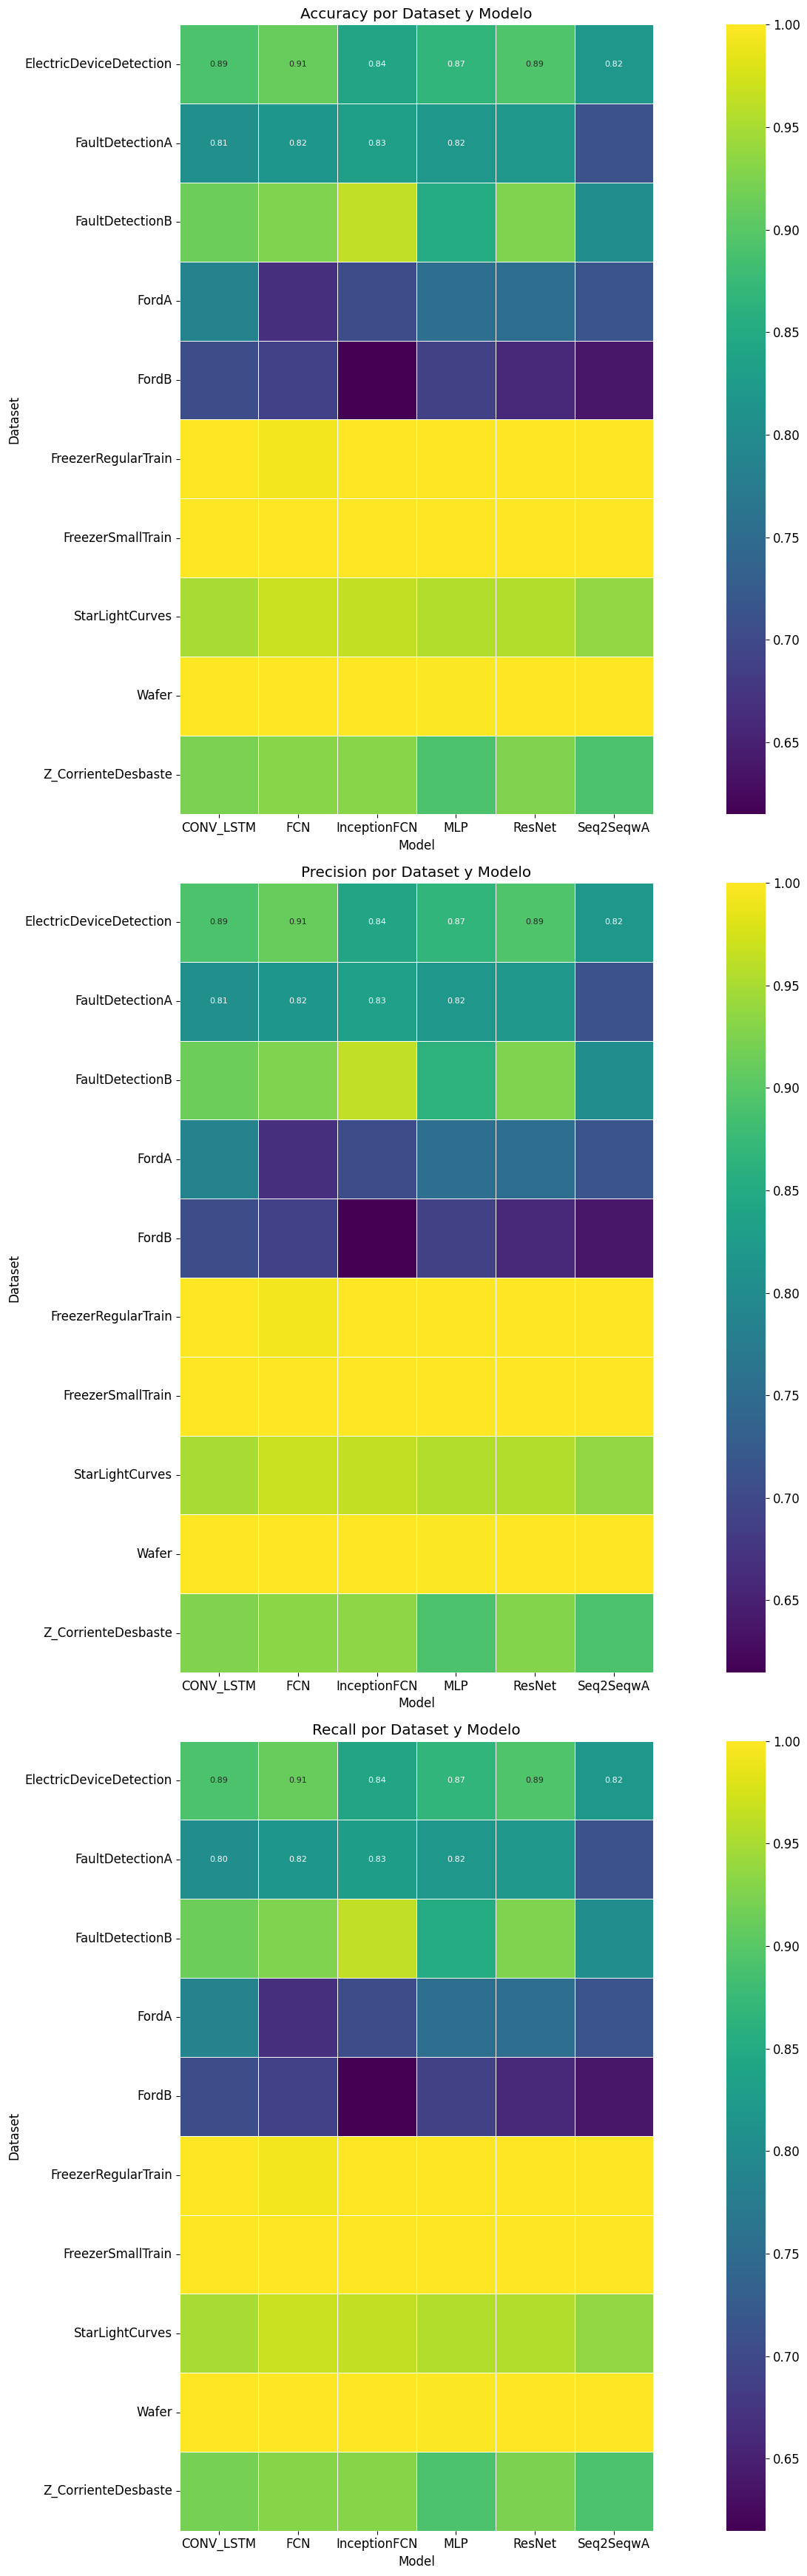

Archivo generado: model_data_organized.xlsx


In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el archivo Excel
df = pd.read_excel('model_comparison_results.xlsx')
# Pivotar la tabla para organizar los datos por dataset y modelo
pivot_df = df.pivot_table(index='Dataset', columns='Model', values=['Accuracy', 'Precision', 'Recall'])

# Mostrar la tabla pivotada
print(pivot_df)

# Crear una visualización con colores para destacar los valores de Accuracy, Precision y Recall
plt.figure(figsize=(20, 35))
metrics = ['Accuracy', 'Precision', 'Recall']

for i, metric in enumerate(metrics, 1):
    plt.subplot(len(metrics), 1, i)
    plt.rcParams.update({'font.size': 12})
    sns.heatmap(pivot_df[metric], annot=True, fmt='.2f', cmap='viridis', cbar=True, annot_kws={"size": 8}, linewidths=0.5, square=True)
    plt.title(f'{metric} por Dataset y Modelo')
    plt.tight_layout()

plt.show()

# Guardar la tabla pivotada en un archivo Excel organizado
with pd.ExcelWriter('model_data_organized.xlsx') as writer:
    pivot_df.to_excel(writer, sheet_name='Pivot Data')
    df.to_excel(writer, sheet_name='Original Data')

print("Archivo generado: model_data_organized.xlsx")

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------